In [1]:
import os
import sys

# If you set up your venv using uv and locally want to run the notebooks, you can use: uv sync --group examples

path_to_project = os.path.dirname(os.path.abspath("")) + "/"
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("decision-focused-learning-codebase"))))

### First, we need the data.

By default, there are two different ways to obtain data -- generate it on the fly or load from a `.pkl` file.
In this notebook, we follow the latter approach.


In [2]:
from src import get_data
from src.registries.data import data_registry
from src.utils.load import print_registry

# Look at implemented functions that generate/load the data
print_registry(data_registry)

Auto-Sklearn cannot be imported.
Name:  load_data_from_dict

Class/function name:  <function load_data_from_dict at 0x10d43ef20>

Parameters:  {'path': None}
Name:  knapsack_pyepo

Class/function name:  <function gen_data_knapsack at 0x10d43f1a0>

Parameters:  {'seed': 5, 'num_data': 1000, 'num_features': 5, 'num_items': 10, 'dimension': 2, 'polynomial_degree': 6, 'noise_width': 0.5}
Name:  shortestpath_5x5

Class/function name:  <function gen_data_shortestpath at 0x10d43f100>

Parameters:  {'seed': 5, 'num_data': 500, 'num_features': 5, 'grid': (5, 5), 'polynomial_degree': 5, 'noise_width': 0.5}
Name:  wsmc_5x25

Class/function name:  <function gen_data_wsmc at 0x11c0cd260>

Parameters:  {'seed': 5, 'num_data': 2500, 'num_features': 5, 'num_items': 5, 'degree': 5, 'noise_width': 0.5}
Name:  wsmc_10x50

Class/function name:  <function gen_data_wsmc at 0x11c0cd260>

Parameters:  {'seed': 5, 'num_data': 2500, 'num_features': 5, 'num_items': 10, 'degree': 5, 'noise_width': 0.5}


In [3]:
# Note that the 'get_data' function returns two outputs (the second one is not relevant here)
# In this notebook, we use a simple knapsack problem.
data_dict, _ = get_data(
    name="knapsack_pyepo",
)
print()
print(data_dict.keys())

Generating data using knapsack_pyepo
Shape of weights: (2, 10), values: (1000, 10), features: (1000, 5).

dict_keys(['c', 'features'])


### Second, we describe the underlying constrained optimization model.
The main way to create optimization models is via the `make_model` function. `make_model` can only create models that were previously registered.

In [4]:
from src.registries.models import model_registry

# Models with prefix `cvxpy` will use differentiable `cvxpy_` solver while `gbpy_` will use non-differentiable Guroby.
print_registry(model_registry, filter_word="knapsack")

Name:  cvxpy_knapsack_pyepo

Class/function name:  <class 'src.concrete_models.cvxpy_knapsack.CVXPYDiffKnapsackModel'>

Parameters:  {'num_decisions': 10, 'capacity': 8, 'values_lb': 3, 'values_ub': 8, 'dimension': 2, 'seed': None}
Name:  grbpy_knapsack_pyepo

Class/function name:  <class 'src.concrete_models.grbpy_knapsack.GRBPYKnapsackModel'>

Parameters:  {'num_decisions': 10, 'capacity': 20, 'weights_lb': 3, 'weights_ub': 8, 'dimension': 2}
Name:  knapsack_2_stage

Class/function name:  <class 'src.concrete_models.grbpy_two_stage_knapsack.TwoStageKnapsack'>

Parameters:  {'num_decision': 10, 'capacity': 22, 'penalty_add': 0.1, 'penalty_remove': 10, 'values_lb': 3.0, 'values_ub': 8.0, 'seed': 5}
Name:  knapsack_2D

Class/function name:  <class 'src.concrete_models.grbpy_knapsack.GRBPYKnapsackModel'>

Parameters:  {'dimension': 2, 'num_decisions': 10, 'capacity': 22, 'weights_lb': 3.0, 'weights_ub': 8.0, 'seed': 5}


In [5]:
from src import make_model

# We will use the cvxpy_ version as it is differentiable and fits better our continuous case.
model_name = "cvxpy_knapsack_pyepo"
model, params = make_model(name=model_name)
# `params` dict contains parameter values used to create optimmization model.
print(params)

{'num_decisions': 10, 'capacity': 8, 'values_lb': 3, 'values_ub': 8, 'dimension': 2, 'seed': None}


In [6]:
# Entries in `params` can be overriden
model, params = make_model(name=model_name, capacity=10)
print(params)

{'num_decisions': 10, 'capacity': 10, 'values_lb': 3, 'values_ub': 8, 'dimension': 2, 'seed': None}


In [7]:
# In our implementation, knapsack is a maximization problem
model.model_sense_int, model.model_sense

(-1, 'MAX')

### Third, we combine data and optimizatoin model to create an instance of DFL Problem.

In [8]:
from src.problem import Problem

# Problem contains data, implementes train/val/test splitting, and allows efficient sampling.
problem = Problem(
    data_dict=data_dict,
    opt_model=model,
    train_ratio=0.7,
    val_ratio=0.15,
    compute_optimal_decisions=True,
    compute_optimal_objectives=True,
    standardize_features=False,
    time_respecting_split=True,
    seed=42,
)

Computing optimal decisions for the entire dataset...
Optimal decisions computed and added to dataset.
Computing optimal objectives for the entire dataset...
Optimal objectives computed and added to dataset.
Dataset split completed: Train=700, Validation=150, Test=150


In [9]:
# For example, we can set the mode (from ['train', 'val', 'test']) and then sample a batch
problem.set_mode("train")
b_inds = problem.generate_batch_indices(batch_size=2)
for inds in b_inds:
    b_data = problem.read_data(inds)
    break
b_data

Problem mode set to: train


{'c': tensor([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [ 9., 19.,  4., 11.,  6., 33., 10., 13.,  3., 33.]]),
 'features': tensor([[-1.3626,  0.7876, -1.7476, -1.1709, -0.8620],
         [ 0.6628,  0.0848,  0.6081,  1.0498,  1.9270]]),
 'x_optimal': tensor([[ 1.7971e-11,  1.0000e+00,  2.6955e-01,  5.7179e-02, -6.8401e-12,
          -5.4876e-11, -3.8280e-11,  1.0000e+00, -3.3305e-11, -3.0466e-11],
         [ 7.4928e-11,  7.6733e-01,  1.0277e-10,  6.4815e-11,  5.0442e-11,
           2.9670e-01,  3.4181e-11,  4.6986e-11, -4.3287e-12,  1.0000e+00]]),
 'objective_optimal': tensor([ 2.3267, 57.3704])}

### Now, we can choose a solution method and solve the DFL problem
In our codebase, algorithms are implemented via the DecisionMaker class.

We begin by usins a simple `DifferentiableDecisionMaker`, which will use differentiability of the CVXPY Layers problems.

In [10]:
from src.decision_makers import DifferentiableDecisionMaker

decision_maker = DifferentiableDecisionMaker(
    problem=problem,
    learning_rate=1e-3,
    batch_size=64,
    device_str="cpu",
    predictor_str="MLP",
    decision_model_str="base",
    loss_function_str="objective",
)

Problem mode set to: train
Problem mode set to: train


In [11]:
problem.dataset[4]

{'c': tensor([1., 1., 7., 1., 1., 1., 1., 1., 7., 1.]),
 'features': tensor([ 1.1891, -0.0736, -2.8597,  0.7894, -1.8777]),
 'x_optimal': tensor([-8.3464e-14, -1.3818e-13,  8.7861e-01, -1.4204e-13, -1.0983e-13,
         -6.2488e-14, -9.7452e-14, -1.1670e-13,  9.4133e-01, -1.4895e-13]),
 'objective_optimal': tensor(12.7396)}

In [12]:
from src.runner import Runner

# We are ready to run the training. We use `runner` to wrap everything together and run the experiments.
runner = Runner(
    decision_maker=decision_maker,
    num_epochs=10,
    experiments_folder="results/",
    main_metric="abs_regret",
    store_min_and_max=False,
    use_wandb=False,
    experiment_name="test_experiment",
    project_name="test_project",
    early_stop=False,
    min_delta_early_stop=None,
    patience_early_stop=None,
    save_best=True,
    seed=None,
    config=None,
)

runner.run()

Epoch 0/10: Starting initial validation...
Problem mode set to: validation
Epoch Results:
validation/x_mean: 0.1957
validation/abs_regret_mean: 7.6161
validation/sym_rel_regret_mean: 0.3466
validation/objective_mean: 11.3885
validation/rel_regret_mean: 0.4882
validation/c_mean: 4.6777
validation/mse_mean: 53.6107
Initial best validation metric (abs_regret): 7.61610746383667
Starting training...
Epoch: 1/10
Problem mode set to: train
Epoch Results:
validation/x_mean: 0.1957
validation/abs_regret_mean: 7.6161
train/rel_regret_mean: 0.4902
train/sym_rel_regret_mean: 0.3485
train/solver_calls_mean: 533.6364
validation/sym_rel_regret_mean: 0.3466
train/grad_norm_mean: 0.0000
train/objective_mean: 9.6518
validation/objective_mean: 11.3885
train/abs_regret_mean: 8.0914
train/loss_mean: -9.6518
validation/rel_regret_mean: 0.4882
validation/c_mean: 4.6777
validation/mse_mean: 53.6107
Problem mode set to: validation
Epoch Results:
validation/x_mean: 0.1956
validation/abs_regret_mean: 8.6421
trai

np.float32(7.6161075)

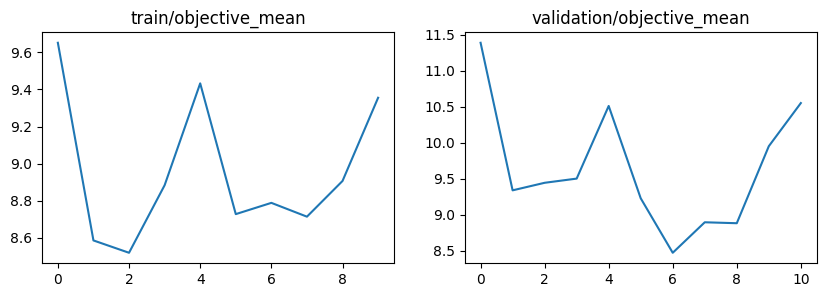

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
metric = "train/objective_mean"
_ = axs[0].plot([d[metric] for d in runner.logger.epoch_metrics_list if metric in d.keys()])
_ = axs[0].set_title(metric)

metric = "validation/objective_mean"
_ = axs[1].plot([d[metric] for d in runner.logger.epoch_metrics_list if metric in d.keys()])
_ = axs[1].set_title(metric)